# 08. Pranjali1049/Salary_Prediction

## Predictions with ML Regression Models - Salary_Data.csv

In [418]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names

In [419]:
df = pd.read_csv('08_Salary_Data.csv')

In [420]:
# Inspect the first and last few rows of the dataset
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [421]:
# All columns, their counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [422]:
# Get statistical info about numerical columns
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


## Preprocessing

All preprocessing steps below were carried out in almost exactly the same way as the author.

In [423]:
# Let's check the number of null values for each column
df.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [424]:
# Drop these rows that contain null values
df.dropna(inplace=True)

In [425]:
print("After the drop, there are now {} rows available in the dataset.".format(len(df)))

After the drop, there are now 6698 rows available in the dataset.


In [426]:
# Check the value counts of each unique job titles
df['Job Title'].value_counts()

Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Software Project Manager        1
Name: Job Title, Length: 191, dtype: int64

In [427]:
# Let's get the number of job titles whose counts are less than 25
job_title_count = df['Job Title'].value_counts()
job_title_edited = job_title_count[job_title_count <= 25]
print("{} job titles were found.".format(job_title_edited.count()))

142 job titles were found.


In [428]:
# Let's find those job titles and change their names as 'Others'
df['Job Title'] = df['Job Title'].apply(lambda x: 'Others' if x in job_title_edited else x)
print("Now, there are {} different job titles exist, including Others.".format(df['Job Title'].nunique()))

Now, there are 50 different job titles exist, including Others.


In [429]:
df['Job Title'].unique()

array(['Software Engineer', 'Data Analyst', 'Others', 'Sales Associate',
       'Marketing Analyst', 'Product Manager', 'Sales Manager',
       'Marketing Coordinator', 'Software Developer', 'Financial Analyst',
       'Operations Manager', 'Marketing Manager', 'Sales Director',
       'Financial Manager', 'Product Designer', 'Data Scientist',
       'Sales Executive', 'Director of Marketing',
       'Senior Data Scientist', 'Digital Marketing Manager',
       'Web Developer', 'Research Director', 'Senior Software Engineer',
       'Content Marketing Manager', 'Sales Representative',
       'Research Scientist', 'Junior Software Developer',
       'Junior Web Developer', 'Junior HR Generalist',
       'Senior HR Generalist', 'Senior Research Scientist',
       'Junior Sales Representative', 'Junior Marketing Manager',
       'Senior Product Marketing Manager', 'Junior Software Engineer',
       'Senior Human Resources Manager', 'Junior HR Coordinator',
       'Director of HR', 'Softwar

In [430]:
# Let's check the value counts of each education Level
df['Education Level'].value_counts()

Bachelor's Degree    2265
Master's Degree      1572
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: Education Level, dtype: int64

In [431]:
# Such strings need to be combined, thus replace those educations appropriately
df['Education Level'].replace(["Bachelor's Degree", "Master's Degree", "phD"],["Bachelor's", "Master's", "PhD"],inplace=True)
df['Education Level'].value_counts()

Bachelor's     3021
Master's       1860
PhD            1369
High School     448
Name: Education Level, dtype: int64

In [432]:
# Now, get the counts of gender
df['Gender'].value_counts()

Male      3671
Female    3013
Other       14
Name: Gender, dtype: int64

In [433]:
# Let's detect the outliers in salary column using IQR method
Q1 = df['Salary'].quantile(0.25)   # First Quartile
Q3 = df['Salary'].quantile(0.75)   # Third Quartile
print("Q1:", Q1, "  Q3:", Q3)
# Caltulate Interquartile
IQR = Q3 - Q1
print("IQR:", IQR)
# Deetect outliers that are 1.5x of IQR above and below Q1 and Q3 resp
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print("LOWER:", lower, "  UPPER:", upper)

Q1: 70000.0   Q3: 160000.0
IQR: 90000.0
LOWER: -65000.0   UPPER: 295000.0


In [434]:
# Good to know there is no outlier at the upper side
df[df['Salary'] > upper]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary


In [435]:
# Likewise, no outlier found at the lower side
df[df['Salary'] < lower]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary


In [436]:
# Now, create dummy variables for regression
dummy_gender = pd.get_dummies(df['Gender'], prefix='gender')
dummy_education = pd.get_dummies(df['Education Level'], prefix='edu')
dummy_job_title = pd.get_dummies(df['Job Title'], prefix='job')
df_sub = pd.concat([dummy_gender, dummy_education, dummy_job_title, df['Age'], df['Years of Experience'], df['Salary']], axis=1)
df_sub

,gender_Female,gender_Male,gender_Other,edu_Bachelor's,edu_High School,edu_Master's,edu_PhD,job_Back end Developer,job_Content Marketing Manager,job_Data Analyst,...,job_Senior Project Engineer,job_Senior Research Scientist,job_Senior Software Engineer,job_Software Developer,job_Software Engineer,job_Software Engineer Manager,job_Web Developer,Age,Years of Experience,Salary
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,32.0,5.0,90000.0
1,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,28.0,3.0,65000.0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,45.0,15.0,150000.0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36.0,7.0,60000.0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,52.0,20.0,200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,49.0,20.0,200000.0
6700,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,32.0,3.0,50000.0
6701,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,30.0,4.0,55000.0
6702,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,46.0,14.0,140000.0


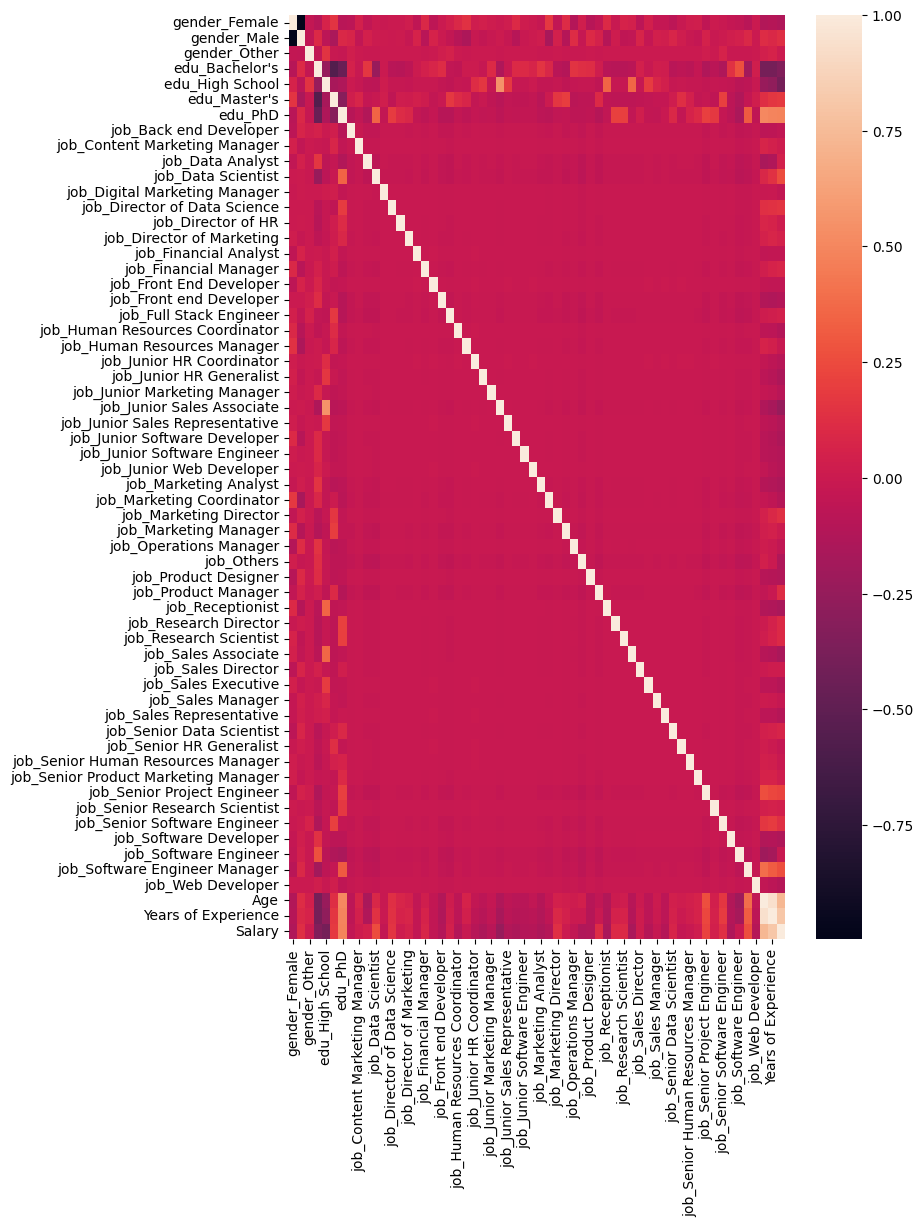

#### COLUMN CORRELATIONS AGAINST SALARIES ####
gender_Female                          -0.127453
gender_Male                             0.126562
gender_Other                            0.009139
edu_Bachelor's                         -0.347662
edu_High School                        -0.398776
edu_Master's                            0.173645
edu_PhD                                 0.483193
job_Back end Developer                 -0.047800
job_Content Marketing Manager           0.015554
job_Data Analyst                        0.044268
job_Data Scientist                      0.259078
job_Digital Marketing Manager          -0.036967
job_Director of Data Science            0.156612
job_Director of HR                      0.012949
job_Director of Marketing               0.049207
job_Financial Analyst                  -0.040068
job_Financial Manager                   0.075060
job_Front End Developer                -0.048972
job_Front end Developer                -0.112192
job_Full Stack Enginee

In [437]:
# The correlations of all presented columns
plt.figure(figsize=(8,12))
sns.heatmap(df_sub.corr())
plt.show()
print("#### COLUMN CORRELATIONS AGAINST SALARIES ####")
print(df_sub.corr()['Salary'])

## Prepare Train and Test Sets

In [438]:
# Use 80% of the dataset as training, and 20% as testing
X = df_sub.drop(columns='Salary', axis=1)
Y = df_sub.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)
x_train

TRAIN SIZE: (5358, 59) (5358,)   TEST SIZE: (1340, 59) (1340,)


,gender_Female,gender_Male,gender_Other,edu_Bachelor's,edu_High School,edu_Master's,edu_PhD,job_Back end Developer,job_Content Marketing Manager,job_Data Analyst,...,job_Senior Product Marketing Manager,job_Senior Project Engineer,job_Senior Research Scientist,job_Senior Software Engineer,job_Software Developer,job_Software Engineer,job_Software Engineer Manager,job_Web Developer,Age,Years of Experience
3426,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,39.0,10.0
1552,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,38.0,10.0
6021,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,35.0,12.0
4461,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30.0,1.0
3286,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,23.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,29.0,4.0
5195,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,38.0,14.0
5230,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25.0,1.0
5395,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,27.0,1.0


In [439]:
# Create lists to store results of error values of all regression methods
res_mse, res_rmse, res_mae, res_r2, res_cv_train, res_cv_test = [], [], [], [], [], []

# ML Regression Models

## 1 - Linear Regression

In [440]:
linreg = LinearRegression()
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [441]:
# Fit the training data into the linear reg. model, then make predictions on the test data
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

In [442]:
print("COEF:", linreg.coef_)   # Estimated coefficients for the linear reg.
print("RANK:", linreg.rank_)   # Rank of matrix
print("INTERCEPT:", linreg.intercept_)   # Independent term in the linear model

COEF: [-1.48275911e+15 -1.48275911e+15 -1.48275911e+15 -9.10262410e+14
 -9.10262411e+14 -9.10262410e+14 -9.10262410e+14  2.99013110e+13
  2.99013110e+13  2.99013110e+13  2.99013110e+13  2.99013110e+13
  2.99013110e+13  2.99013110e+13  2.99013110e+13  2.99013110e+13
  2.99013110e+13  2.99013110e+13  2.99013110e+13  2.99013110e+13
  2.99013109e+13  2.99013110e+13  2.99013109e+13  2.99013109e+13
  2.99013109e+13  2.99013109e+13  2.99013109e+13  2.99013109e+13
  2.99013109e+13  2.99013109e+13  2.99013110e+13  2.99013110e+13
  2.99013110e+13  2.99013110e+13  2.99013110e+13  2.99013109e+13
  2.99013109e+13  2.99013110e+13  2.99013109e+13  2.99013110e+13
  2.99013110e+13  2.99013109e+13  2.99013110e+13  2.99013109e+13
  2.99013110e+13  2.99013109e+13  2.99013110e+13  2.99013109e+13
  2.99013110e+13  2.99013110e+13  2.99013110e+13  2.99013110e+13
  2.99013110e+13  2.99013110e+13  2.99013110e+13  2.99013110e+13
  2.99013109e+13  5.26750000e+02  4.84500000e+03]
RANK: 58
INTERCEPT: 23631202097806

In [443]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

            124589.5 | 150000.0
             88758.0 |  75969.0
            109300.0 | 100000.0
             62396.5 |  60000.0
             74029.0 |  80000.0
            144198.0 | 190000.0
             71147.0 |  72000.0
            104831.0 |  55000.0
            162124.0 | 195000.0
            114532.0 | 130000.0
             94975.5 | 100000.0
             24236.5 |  25000.0
            100316.0 |  70000.0
            125381.0 | 120000.0
            118691.0 | 140000.0
            158106.0 | 195000.0
            110533.0 |  75000.0
            153787.5 | 140000.0
            129847.5 | 130000.0
            109301.0 |  80000.0


In [444]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)         # Mean squared error
print("RMSE:", rmse)       # Root mean squared error
print("MAE:", mae)         # Mean absolute error
print("R2 SCORE:", r2)     # R2 score
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(linreg, X, Y, cv=5, return_train_score=True)    # 5-fold Cross Validation
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'][1:].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 465940759.7266791
RMSE: 21585.66097497779
MAE: 15713.384701492538
R2 SCORE: 0.8365956799268243

# CROSS VALIDATION #
FITTING TIME: [0.03318644 0.02728152 0.02415514 0.02440453 0.02555728] -> 0.026916980743408203
SCORING TIME: [0.00197387 0.00302911 0.00202966 0.00200152 0.0010066 ] -> 0.0020081520080566405
TRAIN SCORE: [0.9178595  0.84491729 0.84742627 0.81448709 0.83604838] -> 0.852147705905932
TEST SCORE: [-0.15038844  0.56293614  0.70443486  0.83156466  0.72934557] -> 0.707070307041462


## 2 - Lasso Regression

In [445]:
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [446]:
# Fit the training data into the lasso model, then make predictions on the test data
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)

In [447]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_) 

COEF: [    -0.            103.74962324 -18042.15678403  -5757.07615877
 -21300.08491931   1359.24553356   2866.40571031  11270.80394898
    958.32700719  40590.6412892   41422.7404025   -4242.88715899
  46519.4702737   -6865.20204979   9923.19991286   3205.16194639
  25976.17967943      0.           4459.80759945  18133.95653716
 -28549.42764826  -5741.31488455 -24743.62197573 -23501.48147502
 -18270.17522946 -20197.84083074 -19683.77394535 -29376.95122796
 -13037.72069457 -22116.83182183 -10408.41043836  -8709.32067069
  48526.07503254   2801.68391088  -4647.22890716 -13570.51523662
 -12888.30562319  40723.57014732 -15324.39073599  38604.69513717
  37089.86959407 -13544.74210098  17131.80724104 -14393.58146789
   5974.63639292 -23424.57661951  24837.41353635 -15574.58877212
  -9085.44552696   2456.35786754  24328.57912044   9036.507292
  12782.93275005  -9057.4910531   32746.6188843   19239.06805931
 -16572.54110272    517.97361183   4859.48811319]
INTERCEPT: 49498.7595225211
ITERATIO

In [448]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  124615.00167291789 | 150000.0
   88741.05262771533 |  75969.0
  109257.47475422604 | 100000.0
   62414.99839620244 |  60000.0
   74106.61724292122 |  80000.0
   144228.6492616597 | 190000.0
   71307.34201524706 |  72000.0
  104695.02385085102 |  55000.0
  162129.07363891928 | 195000.0
  114488.21117609263 | 130000.0
   94952.88585683025 | 100000.0
   24359.49096915334 |  25000.0
  100296.31561708344 |  70000.0
  125440.10475695743 | 120000.0
  118719.56633606435 | 140000.0
  158072.50540413996 | 195000.0
  110533.26545530125 |  75000.0
  153730.99090277567 | 140000.0
  129731.99716255366 | 130000.0
  109115.94376071842 |  80000.0


In [449]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)        
print("R2 SCORE:", r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 465964007.52604127
RMSE: 21586.199469245188
MAE: 15713.73523125479
R2 SCORE: 0.8365875269786894

# CROSS VALIDATION #
FITTING TIME: [0.18467212 0.10985065 0.17091942 0.2473073  0.22427893] -> 0.18740568161010743
SCORING TIME: [0.00200105 0.00099874 0.00599861 0.00197172 0.00198936] -> 0.0025918960571289064
TRAIN SCORE: [0.9178646  0.84491416 0.84758524 0.81455017 0.8360433 ] -> 0.8521914923050693
TEST SCORE: [-0.15172937  0.56237789  0.70729162  0.83629847  0.72913902] -> 0.5366755278630586


## 3 - Ridge Regression

In [450]:
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [451]:
# Fit the training data into the ridge model, then make predictions on the test data
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [452]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [ 5.60243026e+03  5.76651056e+03 -1.13689408e+04 -1.40771419e+01
 -1.63165168e+04  7.26485873e+03  9.06573523e+03  8.46661871e+03
 -1.75318660e+03  3.76717822e+04  3.81070264e+04 -6.93196489e+03
  4.23535295e+04 -9.88688496e+03  6.77014239e+03  5.14144243e+02
  2.29305761e+04 -2.49159364e+03  1.71773479e+03  1.51765279e+04
 -3.06608549e+04 -8.49532730e+03 -2.60005391e+04 -2.54342749e+04
 -2.05744503e+04 -2.19165398e+04 -2.12565453e+04 -3.14270233e+04
 -1.54529180e+04 -2.40812725e+04 -1.30312821e+04 -1.13838736e+04
  4.45229229e+04 -1.32389985e+02 -7.38992090e+03 -1.63052250e+04
 -1.54236309e+04  3.76986725e+04 -1.69623069e+04  3.47849514e+04
  3.32583368e+04 -1.52744969e+04  1.39601736e+04 -1.61730425e+04
  3.41901567e+03 -2.54156163e+04  2.12816519e+04 -1.80479300e+04
 -1.19669963e+04 -5.17163614e+02  2.11699763e+04  5.72624937e+03
  9.71181098e+03 -1.17486601e+04  2.99166017e+04  1.60464246e+04
 -1.90689595e+04  4.83365045e+02  4.91445737e+03]
INTERCEPT: 41610.275637042185
ITER

In [453]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   124739.5215504565 | 150000.0
   88903.98509214666 |  75969.0
  109147.93034576891 | 100000.0
   62444.94001742193 |  60000.0
   74203.92213964384 |  80000.0
   144248.9239877431 | 190000.0
   71742.68438197722 |  72000.0
  104287.98569765768 |  55000.0
  162186.31465622873 | 195000.0
  114526.33742586084 | 130000.0
   94902.56594213161 | 100000.0
  24692.217934526925 |  25000.0
  100159.08168546701 |  70000.0
  125559.04151011904 | 120000.0
  118858.33409293245 | 140000.0
   157844.2914691074 | 195000.0
  110471.36146619405 |  75000.0
  153413.19914590445 | 140000.0
  129798.80011137633 | 130000.0
  108752.11152029136 |  80000.0


In [454]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 466195304.6246729
RMSE: 21591.55632706158
MAE: 15721.983142125668
R2 SCORE: 0.8365064116344147

# CROSS VALIDATION #
FITTING TIME: [0.0124054  0.01155543 0.00863552 0.00759101 0.00699735] -> 0.009436941146850586
SCORING TIME: [0.0017693  0.00157404 0.00200653 0.0019815  0.00251174] -> 0.0019686222076416016
TRAIN SCORE: [0.91782724 0.84484818 0.84753986 0.81448173 0.83595722] -> 0.8521308455953747
TEST SCORE: [-0.15359012  0.56642645  0.70759563  0.84241581  0.72990407] -> 0.5385503670337355


## 4 - Polynomial Regression

In [455]:
poly_feat = PolynomialFeatures(degree=2)
poly_feat.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [456]:
# Fit then transform for both training and test data (the number of columns must increase)
x_poly_train = poly_feat.fit_transform(x_train)
x_poly_test = poly_feat.fit_transform(x_test)
print(x_poly_train.shape, x_poly_test.shape)

(5358, 1830) (1340, 1830)


### Polynomial Regression with Lasso

In [457]:
lasso = Lasso()
lasso.fit(x_poly_train, y_train)
y_poly_pred = lasso.predict(x_poly_test)

In [458]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_) 

COEF: [ 0.00000000e+00 -1.42559459e+04  0.00000000e+00 ... -5.08590527e+01
  1.11436733e+01 -8.24281569e+01]
INTERCEPT: 17771.435233620316
ITERATIONS: 1000


In [459]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)          
print("RMSE:", rmse)     
print("MAE:", mae)         
print("R2 SCORE:", r2)    
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 202797470.98263064
RMSE: 14240.697699994571
MAE: 8922.361431799312
R2 SCORE: 0.928879407592684

# CROSS VALIDATION #
FITTING TIME: [0.19918418 0.10120106 0.1698935  0.25121546 0.22181535] -> 0.18866190910339356
SCORING TIME: [0.00200272 0.0020051  0.00196266 0.00239563 0.00255823] -> 0.0021848678588867188
TRAIN SCORE: [0.9178646  0.84491416 0.84758524 0.81455017 0.8360433 ] -> 0.8521914923050693
TEST SCORE: [-0.15172937  0.56237789  0.70729162  0.83629847  0.72913902] -> 0.5366755278630586


### Polynomial Regression with Ridge

In [460]:
ridge = Ridge()
ridge.fit(x_poly_train, y_train)
y_poly_pred = ridge.predict(x_poly_test)

In [461]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [    0.         -4498.38564415  4096.17326455 ...    28.74725012
  -184.38314948    32.27146249]
INTERCEPT: 66995.21768227988
ITERATIONS: None


In [462]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)        
print("RMSE:", rmse)       
print("MAE:", mae)          
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 202352666.16577047
RMSE: 14225.071745540354
MAE: 9022.220633082965
R2 SCORE: 0.9290353995876898

# CROSS VALIDATION #
FITTING TIME: [0.00953746 0.01005983 0.00956321 0.00818133 0.00854707] -> 0.009177780151367188
SCORING TIME: [0.00300312 0.00199866 0.00299501 0.00152636 0.0019865 ] -> 0.002301931381225586
TRAIN SCORE: [0.91782724 0.84484818 0.84753986 0.81448173 0.83595722] -> 0.8521308455953747
TEST SCORE: [-0.15359012  0.56642645  0.70759563  0.84241581  0.72990407] -> 0.5385503670337355


## 5 - Decision Tree Regression

In [463]:
dtree = DecisionTreeRegressor()
dtree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [464]:
# Fit the training data into the decision tree, then make predictions on the test data
dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)

In [465]:
# The underlying Tree object
print("TREE - NODE COUNT:", dtree.tree_.node_count)  # Total number of nodes involved in the tree
print("TREE - CHILDREN LEFT:", dtree.tree_.children_left)  # id of the left child of node i, -1 if leaf node
print("TREE - CHILDREN RIGHT:", dtree.tree_.children_right)  # id of the right child of node i, -1 if leaf node
print("TREE - FEATURE:", dtree.tree_.feature)  # Features used for splitting node i
print("TREE - THRESHOLD:\n{}".format(dtree.tree_.threshold))  # Threshold value at node i
print("TREE - IMPURITY:\n{}".format(dtree.tree_.impurity))  # The impurity at node i
# Summary of the training samples that reached node i for class j and output k
# print("TREE - VALUE:", dtree.tree_.value)
print("FEATURE IMPORTANCES:\n{}".format(dtree.feature_importances_))  # Return the feature importances
print("MAX FEATURES:", dtree.max_features_)  # The inferred value of max_features
print("FEATURES:", dtree.n_features_in_, "\n")  # Number of features seen during fit

TREE - NODE COUNT: 2135
TREE - CHILDREN LEFT: [ 1  2  3 ... -1 -1 -1]
TREE - CHILDREN RIGHT: [844 441 422 ...  -1  -1  -1]
TREE - FEATURE: [58 58  9 ... -2 -2 -2]
TREE - THRESHOLD:
[ 6.5  3.5  0.5 ... -2.  -2.  -2. ]
TREE - IMPURITY:
[2.76994001e+09 1.29254529e+09 6.93590121e+08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
FEATURE IMPORTANCES:
[2.78632445e-03 3.91467452e-03 1.12451849e-04 5.34956362e-03
 1.27003036e-02 4.96442274e-03 3.55933811e-03 4.22029884e-03
 1.77103895e-04 3.67628497e-02 3.92290036e-02 3.64575603e-05
 2.13260960e-03 1.50342629e-03 6.65273076e-05 1.63959942e-04
 4.17458237e-03 8.62491509e-05 3.07667468e-03 6.45240160e-03
 1.36112393e-04 1.94317811e-04 1.32742012e-04 1.50584389e-04
 2.51552000e-05 2.10506884e-04 1.75742371e-05 8.95371280e-04
 2.68139934e-04 3.58337341e-05 3.78532285e-05 8.16068379e-05
 3.88763698e-04 1.24754960e-03 1.88122390e-04 5.46862618e-03
 1.17130199e-04 1.38668356e-02 0.00000000e+00 5.73036614e-04
 2.37343159e-03 1.31732238e-04 2.74858

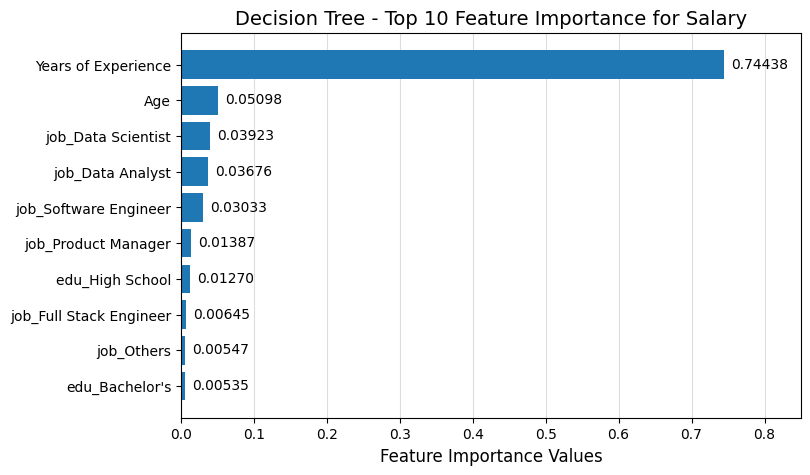

In [466]:
dtree_feat_impr = pd.Series(dtree.feature_importances_, index=df_sub.columns[:x_train.shape[1]]).sort_values(ascending=False)[:10]
plt.figure(figsize=(8,5))
plt.barh(dtree_feat_impr.index[::-1], dtree_feat_impr[::-1], zorder=2)
plt.xlim(0.0, 0.85)
for i in range(len(dtree_feat_impr)):
    plt.text(dtree_feat_impr[i]+0.01, 9-i-0.1, "{:.5f}".format(dtree_feat_impr[i]))
plt.title("Decision Tree - Top 10 Feature Importance for Salary", fontsize=14)
plt.xlabel('Feature Importance Values', fontsize=12)
plt.grid(color='#dddddd', axis='x', zorder=1)
plt.show()

In [467]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

            150000.0 | 150000.0
             75656.0 |  75969.0
            100000.0 | 100000.0
   61571.42857142857 |  60000.0
             80000.0 |  80000.0
  193793.10344827586 | 190000.0
             72000.0 |  72000.0
             55000.0 |  55000.0
   197439.0243902439 | 195000.0
   131891.8918918919 | 130000.0
            100000.0 | 100000.0
   25888.88888888889 |  25000.0
             65000.0 |  70000.0
            130000.0 | 120000.0
            140000.0 | 140000.0
            195000.0 | 195000.0
   82857.14285714286 |  75000.0
            140000.0 | 140000.0
            130000.0 | 130000.0
             80000.0 |  80000.0


In [468]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(dtree, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 79863080.09096062
RMSE: 8936.614576614604
MAE: 2987.2432681395903
R2 SCORE: 0.9719922071018897

# CROSS VALIDATION #
FITTING TIME: [0.02119303 0.01822066 0.01713157 0.01761317 0.01857781] -> 0.018547248840332032
SCORING TIME: [0.00200367 0.00099421 0.00298667 0.00304151 0.00254488] -> 0.002314186096191406
TRAIN SCORE: [0.99810264 0.99165921 0.99136897 0.99050976 0.99182289] -> 0.9926926930220222
TEST SCORE: [-0.19801246  0.83688165  0.93870916  0.86752383  0.70762582] -> 0.6305455980378826


## 6 - Random Forest Regression

In [469]:
rforest = RandomForestRegressor(oob_score=True)
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [470]:
# Fit the training data into the random forest, then make predictions on the test data
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)

In [471]:
# Show the attributes for each random forest
print("BASE ESTIMATOR:", rforest.base_estimator_)   # Estimator used to grow the ensemble
# print("ESTIMATORS:", rforest.estimators_)   # The collection of fitted sub-estimators
print("FEATURE IMPORTANCES:", rforest.feature_importances_)   # The impurity-based feature importances
# Score of the training dataset obtained using an out-of-bag estimate. Exists only when oob_score = True
print("OOB SCORE:", rforest.oob_score_)
# Prediction computed with out-of-bag estimate on the training set. Exists only when oob_score = True
print("OOB PREDICTION:", rforest.oob_prediction_, "", len(rforest.oob_prediction_))
print("FEATURES:", rforest.n_features_in_)   # Number of features seen during fit
print("OUTPUTS:", rforest.n_outputs_, "\n")   # The number of outputs when fit is performed

BASE ESTIMATOR: DecisionTreeRegressor()
FEATURE IMPORTANCES: [2.41812793e-03 3.71436441e-03 1.33532164e-04 5.06755472e-03
 9.95045884e-03 3.38098665e-03 7.07500055e-03 4.68805996e-03
 1.13856644e-04 3.32664679e-02 3.62408457e-02 1.17901589e-04
 1.68927192e-03 1.82709292e-03 2.68108033e-04 2.07009489e-04
 3.37347623e-03 1.83349347e-04 2.79422226e-03 5.84520019e-03
 4.39527559e-05 2.80386875e-04 2.20572821e-04 3.49712865e-04
 3.63706626e-05 1.19290153e-04 4.04566192e-05 7.69839742e-04
 1.06920153e-04 5.00427152e-05 1.40322187e-04 1.68454575e-04
 2.98697311e-03 1.76347140e-03 5.64990180e-04 5.67865276e-03
 8.10555516e-05 1.76632275e-02 0.00000000e+00 3.25843395e-04
 2.52718450e-04 7.06481480e-05 1.48010815e-03 1.05558055e-04
 3.45327379e-04 1.61518826e-04 4.42917039e-04 1.54333104e-04
 5.72439746e-04 3.54583614e-04 3.83473094e-03 9.29641819e-04
 3.53210165e-03 3.74072788e-04 3.14122690e-02 4.40463578e-03
 2.46846925e-04 4.54846507e-02 7.52095474e-01]
OOB SCORE: 0.9782812782857878
OOB PRED

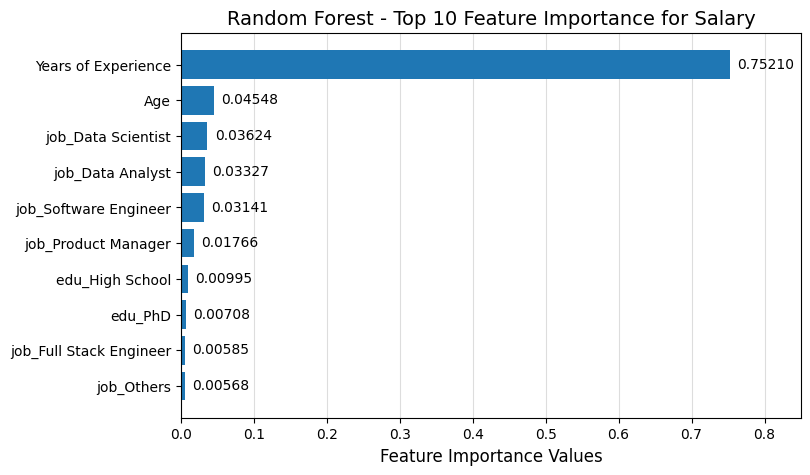

In [472]:
rforest_feat_impr = pd.Series(rforest.feature_importances_, index=df_sub.columns[:x_train.shape[1]]).sort_values(ascending=False)[:10]
plt.figure(figsize=(8,5))
plt.barh(rforest_feat_impr.index[::-1], rforest_feat_impr[::-1], zorder=2)
plt.xlim(0.0, 0.85)
for i in range(len(rforest_feat_impr)):
    plt.text(rforest_feat_impr[i]+0.01, 9-i-0.1, "{:.5f}".format(rforest_feat_impr[i]))
plt.title("Random Forest - Top 10 Feature Importance for Salary", fontsize=14)
plt.xlabel('Feature Importance Values', fontsize=12)
plt.grid(color='#dddddd', axis='x', zorder=1)
plt.show()

In [473]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

            150000.0 | 150000.0
             82389.4 |  75969.0
            100000.0 | 100000.0
  61586.211348941346 |  60000.0
             80000.0 |  80000.0
  193812.69445834658 | 190000.0
             72000.0 |  72000.0
             55093.5 |  55000.0
  197431.05460612525 | 195000.0
  131962.31831593378 | 130000.0
            100000.0 | 100000.0
  25866.627442002442 |  25000.0
   64833.33333333333 |  70000.0
            123237.5 | 120000.0
            140000.0 | 140000.0
            194900.0 | 195000.0
    83267.6672048952 |  75000.0
            140000.0 | 140000.0
            129840.0 | 130000.0
             80000.0 |  80000.0


In [474]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(rforest, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 69489019.87880477
RMSE: 8336.007430347263
MAE: 3173.517288180602
R2 SCORE: 0.9756303654299139

# CROSS VALIDATION #
FITTING TIME: [1.04571962 1.08610845 1.11543989 1.10546875 1.10509849] -> 1.091567039489746
SCORING TIME: [0.02005959 0.01856112 0.01913071 0.01830125 0.01917481] -> 0.019045495986938478
TRAIN SCORE: [0.99749794 0.98983435 0.98948716 0.98852047 0.99016496] -> 0.9911009755216831
TEST SCORE: [-0.18287161  0.87521762  0.96279606  0.91450807  0.74643158] -> 0.6632163450567967


## 7 - KNN Regression

In [475]:
knnreg = KNeighborsRegressor()
knnreg.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [476]:
# Fit the training data into the KNN regression model, then make predictions on the test data
knnreg.fit(x_train, y_train)
y_pred = knnreg.predict(x_test)

In [477]:
# The distance metric to use. It will be the same as the 'metric' parameter or a synonym of it, e.g. 'euclidean' if the
# metric parameter set to 'minkowski' and 'p' parameter is set to 2.
print("EFFECTIVE METRIC:", knnreg.effective_metric_)
# Additional keyword arguments for the metric function. For most metrics will be same with 'metric_params' parameter,
# but may also contain the 'p' parameter value if the 'effective_metric_' attribute is set to 'miknowski'.
print("EFFECTIVE METRIC PARAMS:", knnreg.effective_metric_params_)
print("FEATURES:", knnreg.n_features_in_)  # Number of features seen during fit
print("FEATURE NAMES:", knnreg.feature_names_in_)  # Names of features seen during fit
print("SAMPLES FIT:", knnreg.n_samples_fit_)  # Number of samples in the fitted data

EFFECTIVE METRIC: euclidean
EFFECTIVE METRIC PARAMS: {}
FEATURES: 59
FEATURE NAMES: ['gender_Female' 'gender_Male' 'gender_Other' "edu_Bachelor's"
 'edu_High School' "edu_Master's" 'edu_PhD' 'job_Back end Developer'
 'job_Content Marketing Manager' 'job_Data Analyst' 'job_Data Scientist'
 'job_Digital Marketing Manager' 'job_Director of Data Science'
 'job_Director of HR' 'job_Director of Marketing' 'job_Financial Analyst'
 'job_Financial Manager' 'job_Front End Developer'
 'job_Front end Developer' 'job_Full Stack Engineer'
 'job_Human Resources Coordinator' 'job_Human Resources Manager'
 'job_Junior HR Coordinator' 'job_Junior HR Generalist'
 'job_Junior Marketing Manager' 'job_Junior Sales Associate'
 'job_Junior Sales Representative' 'job_Junior Software Developer'
 'job_Junior Software Engineer' 'job_Junior Web Developer'
 'job_Marketing Analyst' 'job_Marketing Coordinator'
 'job_Marketing Director' 'job_Marketing Manager' 'job_Operations Manager'
 'job_Others' 'job_Product Design

In [478]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

            150000.0 | 150000.0
             78129.2 |  75969.0
            100000.0 | 100000.0
             61000.0 |  60000.0
             80000.0 |  80000.0
            193000.0 | 190000.0
             72000.0 |  72000.0
             55000.0 |  55000.0
            197400.0 | 195000.0
            132000.0 | 130000.0
            100000.0 | 100000.0
             26000.0 |  25000.0
             71000.0 |  70000.0
            130000.0 | 120000.0
            140000.0 | 140000.0
            184000.0 | 195000.0
             75000.0 |  75000.0
            140000.0 | 140000.0
            124000.0 | 130000.0
             80000.0 |  80000.0


In [479]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(knnreg, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 112688716.04456714
RMSE: 10615.494149806082
MAE: 4451.601641791044
R2 SCORE: 0.9604803343755905

# CROSS VALIDATION #
FITTING TIME: [0.00953579 0.00852656 0.00900745 0.00851774 0.0120244 ] -> 0.009522390365600587
SCORING TIME: [0.02105403 0.02004337 0.01955009 0.0357995  0.02362561] -> 0.0240145206451416
TRAIN SCORE: [0.9879694  0.95088646 0.9525015  0.9450056  0.95323928] -> 0.9579204480955387
TEST SCORE: [-0.17666063  0.7205536   0.75044859  0.75320301  0.53620365] -> 0.5167496423974853


## 8 - Gradient Boosting

In [480]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [481]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)

In [482]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x29FBA009740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x29FBA009740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x29FBA009740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x29FBA009740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x29FBA009740)]]
# OF ESTIMATORS: 100
# OF FEATURES: 59
MAX FEATURES: 59
FEATURE IMPORTANCES: [2.69551188e-04 1.41187852e-03 0.00000000e+00 2.97382646e-03
 1.37252965e-02 1.59026956e-03 6.03830641e-03 1.41381638e-03
 2.51491312e-04 3.14796034e-02 4.11091650e-02 0.0000000

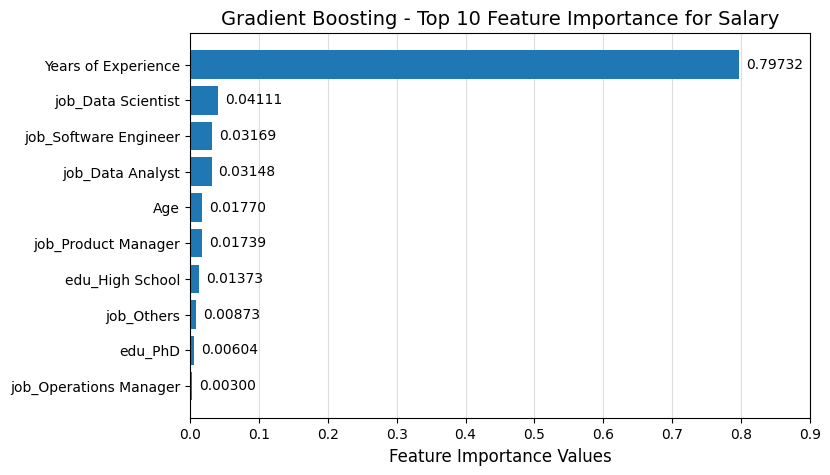

In [483]:
gradBoost_feat_impr = pd.Series(gradBoost.feature_importances_, index=df_sub.columns[:x_train.shape[1]]) \
    .sort_values(ascending=False)[:10]
plt.figure(figsize=(8,5))
plt.barh(gradBoost_feat_impr.index[::-1], gradBoost_feat_impr[::-1], zorder=2)
plt.xlim(0.0, 0.9)
for i in range(len(gradBoost_feat_impr)):
    plt.text(gradBoost_feat_impr[i]+0.01, 9-i-0.1, "{:.5f}".format(gradBoost_feat_impr[i]))
plt.title("Gradient Boosting - Top 10 Feature Importance for Salary", fontsize=14)
plt.xlabel('Feature Importance Values', fontsize=12)
plt.grid(color='#dddddd', axis='x', zorder=1)
plt.show()

In [484]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  137722.80588362427 | 150000.0
   80530.85900538923 |  75969.0
   93171.81583246098 | 100000.0
  63284.764534221955 |  60000.0
   91318.53889581331 |  80000.0
  167529.03244780336 | 190000.0
    89689.6164154854 |  72000.0
   68952.60398047231 |  55000.0
   187802.7645941063 | 195000.0
  125497.03106001088 | 130000.0
   95244.35994147055 | 100000.0
  31554.565012389387 |  25000.0
   70305.15471029452 |  70000.0
  129815.53954952057 | 120000.0
  125807.15061965793 | 140000.0
   151970.8435297071 | 195000.0
  103207.77988903239 |  75000.0
  147930.71909994565 | 140000.0
  143544.94488965123 | 130000.0
  114287.33067928028 |  80000.0


In [485]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 244180851.64410383
RMSE: 15626.287199591074
MAE: 11640.782363716318
R2 SCORE: 0.9143663540807221

# CROSS VALIDATION #
FITTING TIME: [0.46372986 0.45726538 0.46057272 0.46520305 0.46754575] -> 0.4628633499145508
SCORING TIME: [0.00302386 0.00401211 0.00305486 0.00300288 0.00300217] -> 0.0032191753387451174
TRAIN SCORE: [0.95910906 0.92435778 0.91950335 0.90644672 0.9177082 ] -> 0.9254250229063142
TEST SCORE: [-0.18948195  0.80099942  0.88050211  0.88021872  0.81672877] -> 0.6377934155261957


## 9 - XGBoost

In [486]:
xgb = xgboost.XGBRegressor()
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [487]:
# Fit the training data into the extreme gradient boosting regression model, then make predictions on the test data
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

In [488]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

       147819.421875 | 150000.0
       79699.4765625 |  75969.0
       97349.7265625 | 100000.0
      61668.41015625 |  60000.0
           78400.875 |  80000.0
          193182.625 | 190000.0
       73539.3203125 |  72000.0
       55987.3359375 |  55000.0
         197443.4375 | 195000.0
         131009.1875 | 130000.0
         99486.34375 | 100000.0
      26146.12890625 |  25000.0
      62466.57421875 |  70000.0
      117425.8046875 | 120000.0
          139148.125 | 140000.0
       195488.921875 | 195000.0
       97196.4140625 |  75000.0
       139986.140625 | 140000.0
       127905.984375 | 130000.0
        83043.578125 |  80000.0


In [489]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(xgb, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 80333303.43446083
RMSE: 8962.884771905798
MAE: 4524.931497784515
R2 SCORE: 0.9718273008898376

# CROSS VALIDATION #
FITTING TIME: [0.12546015 0.12125564 0.12096596 0.11673021 0.12020636] -> 0.12092366218566894
SCORING TIME: [0.01103044 0.01051664 0.01202512 0.01251531 0.01103115] -> 0.011423730850219726
TRAIN SCORE: [0.99561456 0.98697255 0.9846467  0.98370878 0.98625334] -> 0.9874391853727517
TEST SCORE: [-0.05968567  0.92300964  0.95720331  0.90491379  0.7743218 ] -> 0.6999525721024195


## Results of Metrics of All ML Models Together

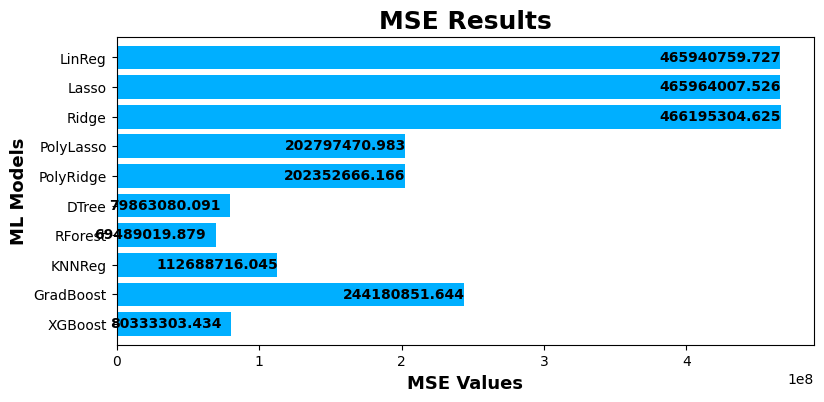

In [490]:
methods = ['LinReg', 'Lasso', 'Ridge', 'PolyLasso', 'PolyRidge', 'DTree', 'RForest', 'KNNReg', 'GradBoost', 'XGBoost']
plt.figure(figsize=(9,4))
plt.barh(range(10), res_mse, color='#00afff')
plt.title("MSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods)
plt.ylim(9.7,-0.7)
plt.xlabel('MSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_mse[i]-85000000, i+0.12, "{:.3f}".format(res_mse[i]), fontweight='bold')
plt.show()

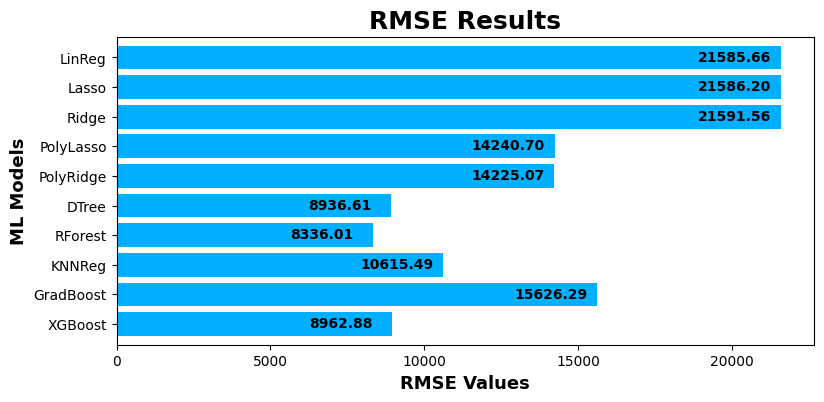

In [491]:
plt.figure(figsize=(9,4))
plt.barh(range(10), res_rmse, color='#00afff')
plt.title("RMSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods)
plt.ylim(9.7,-0.7)
plt.xlabel('RMSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_rmse[i]-2700, i+0.12, "{:.2f}".format(res_rmse[i]), fontweight='bold')
plt.show()

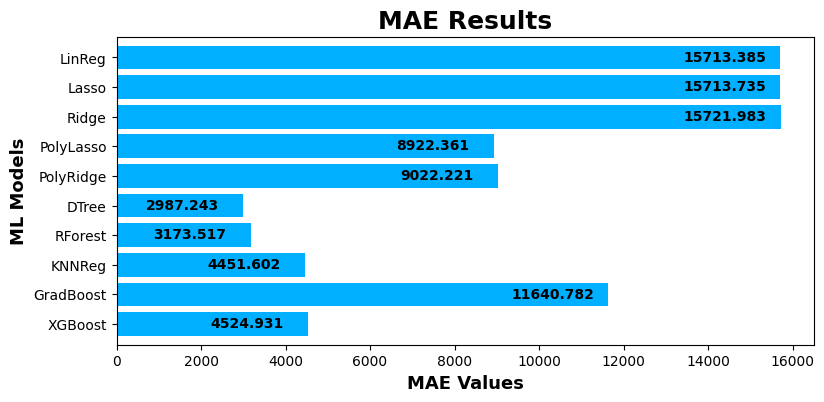

In [492]:
plt.figure(figsize=(9,4))
plt.barh(range(10), res_mae, color='#00afff')
plt.title("MAE Results", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods)
plt.ylim(9.7,-0.7)
plt.xlabel('MAE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_mae[i]-2300, i+0.12, "{:.3f}".format(res_mae[i]), fontweight='bold')
plt.show()

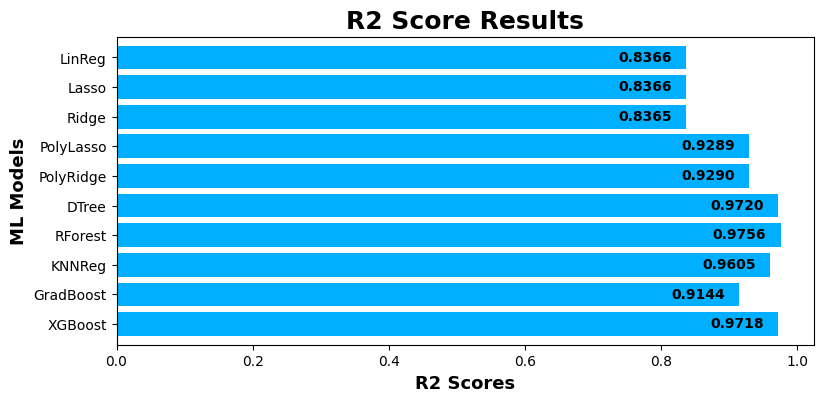

In [493]:
plt.figure(figsize=(9,4))
plt.barh(range(10), res_r2, color='#00afff')
plt.title("R2 Score Results", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods)
plt.ylim(9.7,-0.7)
plt.xlabel('R2 Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_r2[i]-0.1, i+0.12, "{:.4f}".format(res_r2[i]), fontweight='bold')
plt.show()

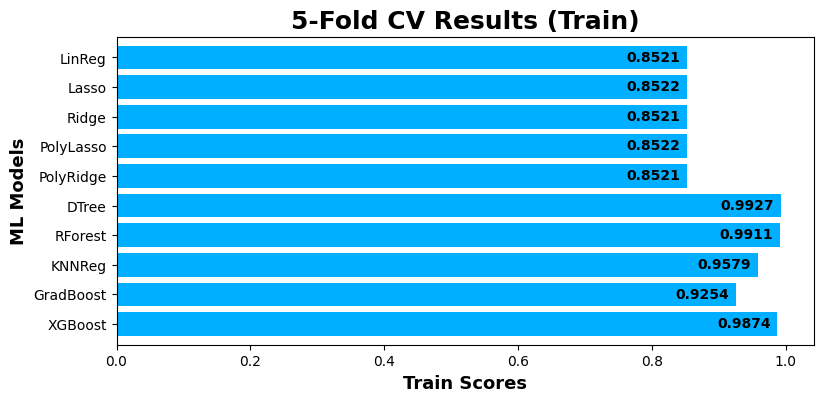

In [494]:
plt.figure(figsize=(9,4))
plt.barh(range(10), res_cv_train, color='#00afff')
plt.title("5-Fold CV Results (Train)", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods)
plt.ylim(9.7,-0.7)
plt.xlabel('Train Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_cv_train[i]-0.09, i+0.12, "{:.4f}".format(res_cv_train[i]), fontweight='bold')
plt.show()

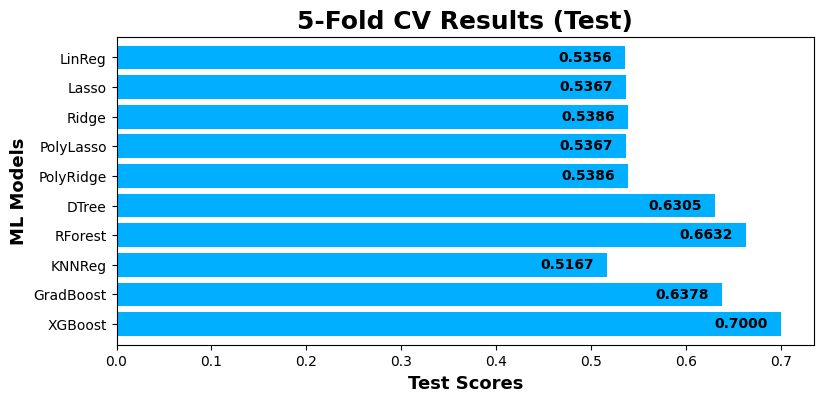

In [495]:
plt.figure(figsize=(9,4))
plt.barh(range(10), res_cv_test, color='#00afff')
plt.title("5-Fold CV Results (Test)", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods)
plt.ylim(9.7,-0.7)
plt.xlabel('Test Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_cv_test[i]-0.07, i+0.12, "{:.4f}".format(res_cv_test[i]), fontweight='bold')
plt.show()